# Modelling by Merchant Segment
## Forecasting Average Order Value in Computer Segment

In [2]:
# Initialise a spark session
import pandas as pd
from collections import Counter
import os
from pyspark.sql import SparkSession
from pyspark.sql.window import Window
from pyspark.sql import functions as F
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml import Pipeline
import matplotlib.pyplot as plt


spark = (
    SparkSession.builder.appName("Computer Model")
    .config("spark.sql.repl.eagerEval.enabled", True)
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.driver.memory", "16g")  # Increase driver memory
    .config("spark.executor.memory", "16g")  # Increase executor memory
    .config("spark.executor.instances", "4")  # Increase the number of executor instances
    .config("spark.driver.maxResultSize", "4g")
    .config("spark.sql.shuffle.partitions", "100") \
    .getOrCreate()
)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/09/25 23:35:04 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
# Read transaction file excluding those marked as fraud
transactions = spark.read.parquet('../data/curated/flagged_fraud')
transactions = transactions.filter(F.col("is_fraud") != True) # Exclude Fraud Transactions

## Filter Transactions by Segment

In [4]:
from pyspark.sql.functions import lower, col

computer_transactions = transactions.filter(lower(col("merchant_category")).contains("computers"))

computer_transactions.show(truncate=False, n=10)


+------------+---------+-------+------------------+------------------------------------+-----------+--------------------------+-----------------+------------------------------+--------------+-----------------+---------------+-------------------------+--------------------------+--------------+----------------+-------------+--------------------------------------+-----------------+---------------------------+---------------------------+--------+------------------------------------------------------+------------+-----------------+
|merchant_abn|year_week|user_id|dollar_value      |order_id                            |consumer_id|fraud_probability_consumer|name_consumer    |address_consumer              |state_consumer|postcode_consumer|gender_consumer|name_merchant            |fraud_probability_merchant|order_datetime|order_month_year|SA4_CODE_2011|SA4_NAME_2011                         |unemployment_rate|consumer_weekly_transaction|merchant_weekly_transaction|is_fraud|merchant_category    

## Feature Engineering: Average Order Values (Yearly)
* Computers often have large purchasing values
* Higher average order values could indicate a focus in more expensive products
* Signaling a higher profit margin
* Averages are calculated yearly to account for annual growth

In [5]:
computer_transactions = computer_transactions.withColumn('order_year', F.year(F.col('order_datetime')))

computer_transactions_df = computer_transactions.groupBy('merchant_abn', 'order_year').agg(
    F.avg('dollar_value').alias('annual_aov'),
    F.count('order_id').alias('total_transactions'),
    F.avg("fraud_probability_merchant").alias("avg_fraud_probability_merchant"),  
    F.avg("fraud_probability_consumer").alias("avg_fraud_probability_consumer"), 
    F.first("name_merchant").alias("merchant_name"),
    F.first("merchant_category").alias("merchant_category")
)

window_spec = Window.partitionBy('merchant_abn').orderBy('order_year')

# Add the lag feature for AOV
annual_aov_df = computer_transactions_df.withColumn(
    'previous_aov', F.lag('annual_aov', 1).over(window_spec)
)

# Calculate the AOV growth rate
annual_aov_df = annual_aov_df.withColumn(
    'aov_growth', 
    F.when(F.col('previous_aov') > 0, 
           (F.col('annual_aov') - F.col('previous_aov')) / F.col('previous_aov')) 
    .otherwise(F.lit(0))  # 0 if there's no previous AOV
)

annual_aov_df = annual_aov_df.fillna({'previous_aov': 0})

In [6]:
annual_aov_df.show(truncate=False, n=5)

+------------+----------+------------------+------------------+------------------------------+------------------------------+-------------------------+-------------------------------------------------------+------------------+-------------------+
|merchant_abn|order_year|annual_aov        |total_transactions|avg_fraud_probability_merchant|avg_fraud_probability_consumer|merchant_name            |merchant_category                                      |previous_aov      |aov_growth         |
+------------+----------+------------------+------------------+------------------------------+------------------------------+-------------------------+-------------------------------------------------------+------------------+-------------------+
|10255988167 |2021      |333.32024900941076|468               |55.25293598767647             |12.611948854975545            |Aliquam Enim Incorporated|computers, comPUter peripheral equipment, and softwAre |0.0               |0.0                |
|10255988167

## Random Forest Regression to Forecast Future Annual AOV

In [7]:
feature_columns = ['total_transactions', 'avg_fraud_probability_merchant', 
                   'avg_fraud_probability_consumer', 'previous_aov', 'aov_growth']

assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

scaler = StandardScaler(inputCol="features", outputCol="scaled_features")

rf = RandomForestRegressor(featuresCol="scaled_features", labelCol="annual_aov")

pipeline = Pipeline(stages=[assembler, scaler, rf])

In [8]:
train_data, test_data = annual_aov_df.randomSplit([0.8,0.2], seed=42)

rf_model = pipeline.fit(train_data)

predictions = rf_model.transform(test_data)

evaluator = RegressionEvaluator(labelCol="annual_aov", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
r2 = evaluator.evaluate(predictions, {evaluator.metricName: "r2"})

print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R²): {r2}")

predictions.select("merchant_abn", "order_year", "annual_aov", "prediction").show(5)

24/09/25 23:35:15 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


Root Mean Squared Error (RMSE): 88.84787174128903
R-squared (R²): 0.6218727414630009


+------------+----------+------------------+------------------+
|merchant_abn|order_year|        annual_aov|        prediction|
+------------+----------+------------------+------------------+
| 10342410215|      2021| 341.4296338854115| 299.7364597300021|
| 10648956813|      2021| 64.20377809545332|186.97913107790578|
| 10854978569|      2021| 327.3592671417361|  329.518492206567|
| 12171241826|      2022| 209.3676047974551|238.42768500657127|
| 13902377680|      2022|224.90111290011623| 292.9340573796893|
+------------+----------+------------------+------------------+
only showing top 5 rows



In [9]:
annual_aov_df.show(truncate=False, n=5)

+------------+----------+------------------+------------------+------------------------------+------------------------------+-------------------------+-------------------------------------------------------+------------------+-------------------+
|merchant_abn|order_year|annual_aov        |total_transactions|avg_fraud_probability_merchant|avg_fraud_probability_consumer|merchant_name            |merchant_category                                      |previous_aov      |aov_growth         |
+------------+----------+------------------+------------------+------------------------------+------------------------------+-------------------------+-------------------------------------------------------+------------------+-------------------+
|10255988167 |2021      |333.32024900941076|468               |55.25293598767647             |12.611948854975545            |Aliquam Enim Incorporated|computers, comPUter peripheral equipment, and softwAre |0.0               |0.0                |
|10255988167

## Predicting Future Annual AOV

In [10]:
future_aov_df = annual_aov_df.groupBy('merchant_abn').agg(F.max('order_year').alias('latest_year'))

num_future_years = 1  # Number of future years to project
future_years = [(year,) for year in range(2023, 2023 + num_future_years)]  # Specify the future years you want to predict
future_years_df = spark.createDataFrame(future_years, ['order_year'])

future_data = future_aov_df.crossJoin(future_years_df)

latest_data = annual_aov_df.groupBy('merchant_abn').agg(
    F.max('order_year').alias('latest_year'),
    F.last('annual_aov').alias('annual_aov'),
    F.last('total_transactions').alias('total_transactions'),
    F.last('avg_fraud_probability_merchant').alias('avg_fraud_probability_merchant'),
    F.last('avg_fraud_probability_consumer').alias('avg_fraud_probability_consumer'),
    F.last('previous_aov').alias('previous_aov'),
    F.first('merchant_name').alias('merchant_name'),
    F.first('merchant_category').alias('merchant_category'),
    F.last('aov_growth').alias('aov_growth')
)

future_data = future_data.join(latest_data, on='merchant_abn', how='left')

future_data = rf_model.transform(future_data)

future_data.select('merchant_abn', 'order_year', 'prediction').show(10)

+------------+----------+------------------+
|merchant_abn|order_year|        prediction|
+------------+----------+------------------+
| 87632767975|      2023|359.42876542645456|
| 10648956813|      2023|182.72738225976173|
| 18112900644|      2023| 69.23767718339083|
| 15514494276|      2023|251.21333374511943|
| 23617533061|      2023| 333.5038902704189|
| 46674437504|      2023| 280.8625986750675|
| 96435855846|      2023| 451.5748087108139|
| 32069730393|      2023|217.39890237178878|
| 69135584329|      2023| 351.7675962990834|
| 84937597269|      2023|449.44009287093604|
+------------+----------+------------------+
only showing top 10 rows



In [11]:
future_predictions = future_data.withColumnRenamed('prediction', 'projected_annual_aov')
future_predictions = future_predictions.orderBy(F.col('projected_annual_aov').desc())

In [12]:
future_predictions = future_predictions.select('merchant_abn', 'merchant_name','merchant_category', 'order_year', 'total_transactions',
                                               'avg_fraud_probability_merchant', 'avg_fraud_probability_consumer', 
                                               'projected_annual_aov', 'aov_growth')

In [13]:
future_predictions.show(truncate=False, n=10)

+------------+----------------------------+-------------------------------------------------------+----------+------------------+------------------------------+------------------------------+--------------------+-------------------+
|merchant_abn|merchant_name               |merchant_category                                      |order_year|total_transactions|avg_fraud_probability_merchant|avg_fraud_probability_consumer|projected_annual_aov|aov_growth         |
+------------+----------------------------+-------------------------------------------------------+----------+------------------+------------------------------+------------------------------+--------------------+-------------------+
|87898093521 |Donec Felis Orci Corporation|computers, computer peripheral equipment, and software |2023      |6                 |31.477699665709896            |14.00195523370359             |631.3319906309887   |0.39139435228418973|
|87122475882 |Lectus Sit Incorporated     |computers, computer perip

## Export Ranking and Relevant Columns

In [14]:
future_predictions = future_predictions.select('merchant_abn', 'merchant_name', 'merchant_category', 'order_year', 'projected_annual_aov')

In [15]:
future_predictions.write.parquet('../data/curated/computer_ranking')

## Model Evaluation

In [36]:
rf_stage = rf_model.stages[-1] 
importances = rf_stage.featureImportances
importance_values = importances.toArray()
feature_importance_df = pd.DataFrame({
    'Feature': feature_columns,
    'Importance': importance_values
})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)


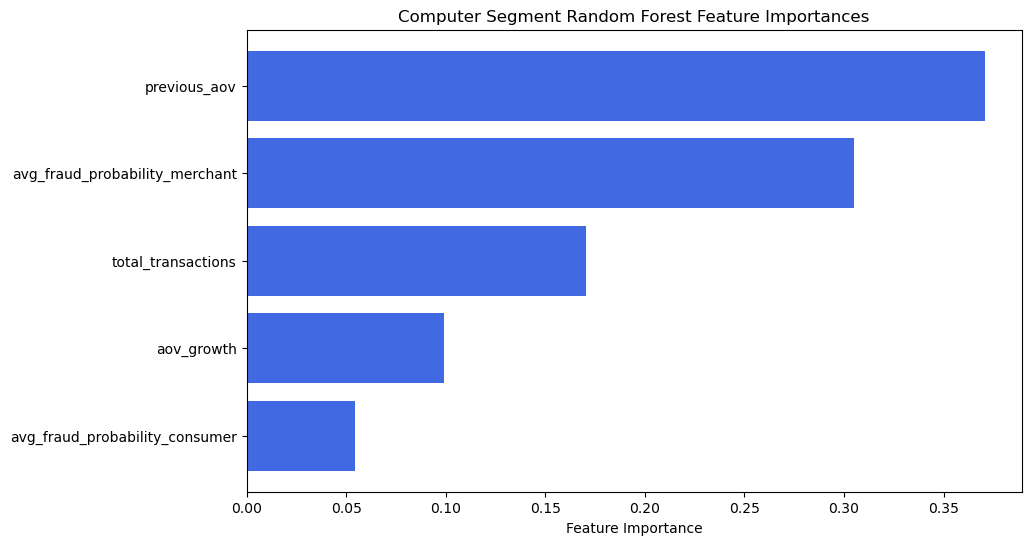

In [38]:
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='royalblue')
plt.xlabel('Feature Importance')
plt.title('Computer Segment Random Forest Feature Importances')
plt.gca().invert_yaxis()  # To have the highest importance on top
plt.show()